In [60]:
import numpy as np
import pandas as pd
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers, Sequential, Model
import matplotlib.pyplot as plt

In [61]:
#!pip install tensorflow

In [62]:
from warnings import filterwarnings
filterwarnings('ignore')

### Data fields
ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category


In [63]:
train=pd.read_csv('sales_train.csv')
item_categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
ss=pd.read_csv('sample_submission.csv')
shops=pd.read_csv('shops.csv')
test=pd.read_csv('test.csv')

In [64]:
train.head(10)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
5  10.01.2013               0       25     2564      349.00           1.0
6  02.01.2013               0       25     2565      549.00           1.0
7  04.01.2013               0       25     2572      239.00           1.0
8  11.01.2013               0       25     2572      299.00           1.0
9  03.01.2013               0       25     2573      299.00           3.0

In [65]:
train.shape

(2935849, 6)

In [66]:
train['item_cnt_day'].value_counts()

1.0      2629372
2.0       194201
3.0        47350
4.0        19685
5.0        10474
          ...   
179.0          1
187.0          1
194.0          1
195.0          1
508.0          1
Name: item_cnt_day, Length: 198, dtype: int64

In [67]:
train['date_block_num'].value_counts()

11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
13     89830
24     88522
19     86614
22     86428
17     82408
21     79361
18     78760
16     78529
15     77906
20     73157
25     71808
26     69977
31     57029
27     56274
30     55549
29     54617
28     54548
33     53514
32     50588
Name: date_block_num, dtype: int64

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [69]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [70]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [71]:
item_categories.shape

(84, 2)

In [72]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [73]:
item_categories.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [74]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [75]:
items.shape

(22170, 3)

In [76]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [77]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [78]:
ss.head()

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5

In [79]:
ss.shape

(214200, 2)

In [80]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [81]:
shops.shape

(60, 2)

In [82]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [83]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [84]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [85]:
test.shape

(214200, 3)

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [87]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

### EDA

In [88]:
print(test[~test.item_id.isin(train.item_id)].shape)
print(test[~test.shop_id.isin(train.shop_id)].shape)
print(test.ID.nunique())
print(test.shop_id.nunique())
print(test.item_id.nunique())

(15246, 3)
(0, 3)
214200
42
5100


In [89]:
print(test[test.item_id.isin(train.item_id)].shape)

(198954, 3)


In [90]:
test.shape

(214200, 3)

In [91]:
print(items.item_id.nunique())
print(items.item_category_id.nunique())
print(test[~test.item_id.isin(items.item_id)].shape)

22170
84
(0, 3)


In [92]:
print(train[~train.item_id.isin(items.item_id)]['item_id'].nunique())
print(test[~test.item_id.isin(train.item_id)]['item_id'].nunique())

0
363


In [93]:
train = train[train['shop_id'].isin(test['shop_id'])]
train = train[train['item_id'].isin(test['item_id'].unique())]

In [94]:
train_data=pd.merge(train,items,on='item_id',how='inner')
train_data.drop('item_name',axis=1,inplace=True)
train_data.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  02.01.2013               0       25    22154       999.0           1.0   
3  03.01.2013               0       25    22154       999.0           1.0   
4  20.01.2013               0       25    22154       999.0           1.0   

   item_category_id  
0                37  
1                37  
2                37  
3                37  
4                37

In [95]:
train_data.shape

(1224439, 7)

In [96]:
train_data['item_cnt_month']=train_data.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].transform('sum')
train_data['monthly_sales']=train_data.groupby('date_block_num')['item_cnt_day'].transform('sum')
train_data.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  23.01.2013               0       24    22154       999.0           1.0   
2  02.01.2013               0       25    22154       999.0           1.0   
3  03.01.2013               0       25    22154       999.0           1.0   
4  20.01.2013               0       25    22154       999.0           1.0   

   item_category_id  item_cnt_month  monthly_sales  
0                37             1.0        20612.0  
1                37             1.0        20612.0  
2                37             5.0        20612.0  
3                37             5.0        20612.0  
4                37             5.0        20612.0

In [97]:
train_data.shape

(1224439, 9)

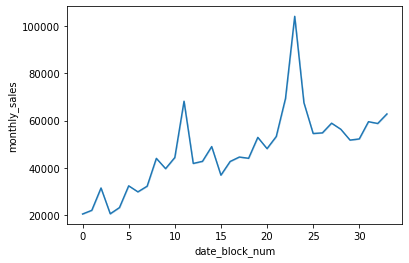

In [98]:
sns.lineplot(x='date_block_num', y='monthly_sales', data=train_data)
plt.show()

In [99]:
print(train_data['item_cnt_month'].min())
print(train_data['item_cnt_month'].max())
print(train_data['item_cnt_month'].mean())
print(train_data['item_cnt_month'].median())

-4.0
2253.0
9.854100530937025
3.0


In [100]:
train_data=train_data[(train_data.item_cnt_month>=0) & (train_data.item_cnt_month<=15)]

In [101]:
print(train_data['item_cnt_month'].min())
print(train_data['item_cnt_month'].max())
print(train_data['item_cnt_month'].mean())
print(train_data['item_cnt_month'].median())

0.0
15.0
3.6265636426707526
2.0


### Model

In [102]:
mat= train_data.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',values='item_cnt_month', fill_value=0).reset_index()
mat.head()

date_block_num  shop_id  item_id  0  1  2  3  4  5  6  7  ...  24  25  26  27  \
0                     2       30  0  0  1  0  0  1  0  0  ...   0   0   0   0   
1                     2       31  0  4  1  1  0  0  0  0  ...   0   0   0   0   
2                     2       32  0  0  0  0  0  0  0  0  ...   0   0   1   0   
3                     2       33  1  0  0  0  0  0  0  0  ...   0   1   0   1   
4                     2       53  0  0  0  0  0  0  0  0  ...   0   1   0   0   

date_block_num  28  29  30  31  32  33  
0                0   0   0   0   0   0  
1                0   0   0   0   0   1  
2                0   0   0   1   0   0  
3                1   0   1   0   1   0  
4                0   0   0   0   0   0  

[5 rows x 36 columns]

In [103]:
first = 20
last = 33
sub_series = 12
l = []

for index, row in mat.iterrows():
    for i in range((last - (first + sub_series)) + 1):
        x = [row['shop_id'], row['item_id']]
        for j in range(sub_series + 1):
            x.append(row[i + first + j])
        l.append(x)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(sub_series)]
columns.append('label')

mat1 = pd.DataFrame(l, columns=columns)
mat1.head()

shop_id  item_id  0  1  2  3  4  5  6  7  8  9  10  11  label
0        2       30  0  0  0  0  0  0  0  0  0  0   0   0      0
1        2       30  0  0  0  0  0  0  0  0  0  0   0   0      0
2        2       31  0  0  0  0  0  0  0  0  0  0   0   0      0
3        2       31  0  0  0  0  0  0  0  0  0  0   0   0      1
4        2       32  2  2  0  2  0  0  1  0  0  0   0   1      0

In [104]:
mat1[(mat1['shop_id']==2) & (mat1['item_id']==31)]

shop_id  item_id  0  1  2  3  4  5  6  7  8  9  10  11  label
2        2       31  0  0  0  0  0  0  0  0  0  0   0   0      0
3        2       31  0  0  0  0  0  0  0  0  0  0   0   0      1

In [105]:
y = mat1['label']
mat1.drop(['label','shop_id','item_id'], axis=1, inplace=True)

In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(mat1, y.values, test_size=0.1, random_state=0)

In [107]:
print(X_train.shape)
print(X_valid.shape)


(200188, 12)
(22244, 12)


In [108]:
# from sklearn.preprocessing import StandardScaler
# scale=StandardScaler()
# X_train=scale.fit_transform(X_train)
# X_valid=scale.transform(X_valid)

In [109]:
X_train1 = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid1 = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [110]:
lstm_model = Sequential()
lstm_model.add(LSTM(X_train1.shape[1], input_shape=(X_train1.shape[1], X_train1.shape[2]), return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(1, activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(0.0001)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 12)            672       
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 6)             456       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
____________________________________________________

In [111]:
lstm_model.fit(X_train1, y_train, validation_data=(X_valid1, y_valid), batch_size=128, epochs=10, verbose=1)

Epoch 1/10
1564/1564 [==============================] - 24s 13ms/step - loss: 1.2261 - val_loss: 1.1151
Epoch 2/10
1564/1564 [==============================] - 20s 13ms/step - loss: 1.1037 - val_loss: 1.0782
Epoch 3/10
1564/1564 [==============================] - 20s 13ms/step - loss: 1.0743 - val_loss: 1.0526
Epoch 4/10
1564/1564 [==============================] - 22s 14ms/step - loss: 1.0473 - val_loss: 1.0269
Epoch 5/10
1564/1564 [==============================] - 20s 13ms/step - loss: 1.0131 - val_loss: 0.9892
Epoch 6/10
1564/1564 [==============================] - 20s 13ms/step - loss: 0.9884 - val_loss: 0.9752
Epoch 7/10
1564/1564 [==============================] - 20s 13ms/step - loss: 0.9774 - val_loss: 0.9657
Epoch 8/10
1564/1564 [==============================] - 20s 13ms/step - loss: 0.9711 - val_loss: 0.9615
Epoch 9/10
1564/1564 [==============================] - 20s 13ms/step - loss: 0.9676 - val_loss: 0.9612
Epoch 10/10
1564/1564 [==============================] - 20s 13m

In [112]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score
preds=lstm_model.predict(X_valid1)
print('MAE',mean_absolute_error(y_valid, preds))
print('MSE',mean_squared_error(y_valid, preds))

MAE 0.5216886831934496
MSE 0.9548013759034036


In [113]:
final = mat.drop_duplicates(subset=['shop_id', 'item_id'])
X_test = pd.merge(test, final, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['ID', 'item_id', 'shop_id'], axis=1, inplace=True)
X_test = X_test[[(i + (34 - sub_series )) for i in range(sub_series )]]
X_test.head()

22   23   24   25   26   27   28   29   30   31   32   33
0  1.0  2.0  2.0  0.0  0.0  0.0  1.0  1.0  1.0  3.0  1.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  3.0  2.0  0.0  1.0  3.0  1.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [114]:
#X_test=scale.transform(X_test)
X_test1 = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
preds=lstm_model.predict(X_test1)

In [115]:
sub=pd.DataFrame(test['ID'])
sub['item_cnt_month']=preds
sub

ID  item_cnt_month
0            0        0.529298
1            1        0.427244
2            2        0.771935
3            3        0.229767
4            4        0.427244
...        ...             ...
214195  214195        0.352872
214196  214196        0.427244
214197  214197        0.083996
214198  214198        0.427244
214199  214199        0.427244

[214200 rows x 2 columns]

In [116]:
#sub.to_csv('subm.csv', index=False)